# Task 3.1

In [1]:
# Imports
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split

# Reproducibility
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

## Data generation
We generate 2D points and assign a binary label by thresholding the radius (non-linear circular decision boundary). The DataGenerator class returns PyTorch Datasets for training, validation and test splits.

In [2]:
class SyntheticCircleDataset(Dataset):
    """2D points labeled by whether x^2+y^2 > radius^2.
    Produces floats (features) and floats (labels 0.0/1.0) for BCEWithLogitsLoss.
    """
    def __init__(self, n_samples:int=1000, radius:float=0.7, noise:float=0.1, transform=None):
        self.n_samples = n_samples
        self.radius = radius
        self.noise = noise
        self.transform = transform

        # sample uniformly in a square [-1.5, 1.5]^2
        X = np.random.uniform(-1.5, 1.5, size=(n_samples, 2))
        r2 = X[:,0]**2 + X[:,1]**2
        # label: 1 if outside radius (non-linear), 0 otherwise, add label noise
        labels = (r2 > radius**2).astype(float)
        if noise>0:
            flip_idx = np.random.choice(n_samples, size=int(noise*n_samples), replace=False)
            labels[flip_idx] = 1.0 - labels[flip_idx]

        # standardize features using training-like stats (here global)
        self.X = X.astype(np.float32)
        self.y = labels.astype(np.float32).reshape(-1,1)

    def __len__(self):
        return self.n_samples

    def __getitem__(self, idx):
        x = self.X[idx]
        y = self.y[idx]
        if self.transform is not None:
            x = self.transform(x)
        # return tensors
        return torch.from_numpy(x), torch.from_numpy(y)

def make_dataloaders(total_samples=1200, train_frac=0.6, val_frac=0.2, batch_size=64, **dataset_kwargs):
    dataset = SyntheticCircleDataset(n_samples=total_samples, **dataset_kwargs)
    n_train = int(total_samples * train_frac)
    n_val = int(total_samples * val_frac)
    n_test = total_samples - n_train - n_val
    train_set, val_set, test_set = random_split(dataset, [n_train, n_val, n_test], generator=torch.Generator().manual_seed(SEED))

    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)
    return train_loader, val_loader, test_loader, dataset

## Model
A small feedforward network with configurable hidden sizes. For binary classification we output a single logit (no sigmoid inside the model). Loss used will be BCEWithLogitsLoss.

In [3]:
class FeedForwardNet(nn.Module):
    def __init__(self, input_dim=2, hidden_sizes=[16, 16], dropout=0.0):
        super().__init__()
        layers = []
        in_dim = input_dim
        for h in hidden_sizes:
            layers.append(nn.Linear(in_dim, h))
            layers.append(nn.ReLU())
            if dropout>0:
                layers.append(nn.Dropout(dropout))
            in_dim = h
        # final logit layer
        layers.append(nn.Linear(in_dim, 1))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        # expect x shape (batch, 2)
        return self.net(x).squeeze(-1)  # returns (batch,) logits

## Training utilities
Includes training loop, evaluation, and plotting helpers. Uses BCEWithLogitsLoss (numerically stable) and Adam optimizer.

In [4]:
def evaluate(model:nn.Module, loader:DataLoader, device='cpu') -> Tuple[float,float]:
    model.eval()
    loss_fn = nn.BCEWithLogitsLoss()
    total_loss = 0.0
    total = 0
    correct = 0
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device).float()
            yb = yb.to(device).float().squeeze(-1)
            logits = model(xb)
            loss = loss_fn(logits, yb)
            total_loss += loss.item() * xb.size(0)
            preds = (torch.sigmoid(logits) > 0.5).float()
            correct += (preds == yb).sum().item()
            total += xb.size(0)
    return total_loss/total, correct/total

def train_model(model:nn.Module, train_loader:DataLoader, val_loader:DataLoader,
                epochs:int=50, lr:float=1e-3, device='cpu'):
    model.to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.BCEWithLogitsLoss()

    history = {'train_loss':[], 'val_loss':[], 'train_acc':[], 'val_acc':[]}
    for ep in range(1, epochs+1):
        model.train()
        running_loss = 0.0
        total = 0
        correct = 0
        for xb, yb in train_loader:
            xb = xb.to(device).float()
            yb = yb.to(device).float().squeeze(-1)
            opt.zero_grad()
            logits = model(xb)
            loss = loss_fn(logits, yb)
            loss.backward()
            opt.step()
            running_loss += loss.item() * xb.size(0)
            preds = (torch.sigmoid(logits) > 0.5).float()
            correct += (preds == yb).sum().item()
            total += xb.size(0)
        train_loss = running_loss/total
        train_acc = correct/total
        val_loss, val_acc = evaluate(model, val_loader, device=device)
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        if ep % max(1, epochs//10) == 0 or ep==1:
            print(f'Epoch {ep:3d}/{epochs} | train_loss={train_loss:.4f} acc={train_acc:.3f} | val_loss={val_loss:.4f} acc={val_acc:.3f}')
    return history

## Visualization helpers
Plot training/validation losses and decision boundary + scatter of train/val points.

In [5]:
def plot_losses(history):
    plt.figure(figsize=(6,4))
    plt.plot(history['train_loss'], label='train loss')
    plt.plot(history['val_loss'], label='val loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and validation loss')
    plt.grid(True)
    plt.show()

def plot_decision_boundary(model, dataset, title='Decision boundary', device='cpu', grid_steps=200):
    model.to(device).eval()
    X = dataset.X
    y = dataset.y.squeeze(-1)
    x_min, x_max = X[:,0].min()-0.2, X[:,0].max()+0.2
    y_min, y_max = X[:,1].min()-0.2, X[:,1].max()+0.2
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, grid_steps), np.linspace(y_min, y_max, grid_steps))
    grid = np.c_[xx.ravel(), yy.ravel()]
    with torch.no_grad():
        logits = model(torch.from_numpy(grid).float().to(device))
        probs = torch.sigmoid(logits).cpu().numpy()
    Z = (probs > 0.5).astype(int).reshape(xx.shape)
    plt.figure(figsize=(6,5))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap='RdYlBu')
    plt.scatter(X[:,0], X[:,1], c=y, cmap='bwr', edgecolor='k')
    plt.title(title)
    plt.show()

## Run training (example configuration)
Modify hyperparameters as needed. This cell constructs dataloaders, model, trains and plots results.

Device: cpu
Epoch   1/60 | train_loss=0.6597 acc=0.751 | val_loss=0.6208 acc=0.817
Epoch   6/60 | train_loss=0.4474 acc=0.810 | val_loss=0.4186 acc=0.817
Epoch  12/60 | train_loss=0.3942 acc=0.810 | val_loss=0.3633 acc=0.817
Epoch  18/60 | train_loss=0.3555 acc=0.810 | val_loss=0.3197 acc=0.817
Epoch  24/60 | train_loss=0.3213 acc=0.842 | val_loss=0.2884 acc=0.846
Epoch  30/60 | train_loss=0.3194 acc=0.889 | val_loss=0.2693 acc=0.904
Epoch  36/60 | train_loss=0.3012 acc=0.911 | val_loss=0.2581 acc=0.908
Epoch  42/60 | train_loss=0.3036 acc=0.914 | val_loss=0.2504 acc=0.929
Epoch  48/60 | train_loss=0.2932 acc=0.922 | val_loss=0.2443 acc=0.929
Epoch  54/60 | train_loss=0.2909 acc=0.910 | val_loss=0.2410 acc=0.933
Epoch  60/60 | train_loss=0.2898 acc=0.918 | val_loss=0.2424 acc=0.933


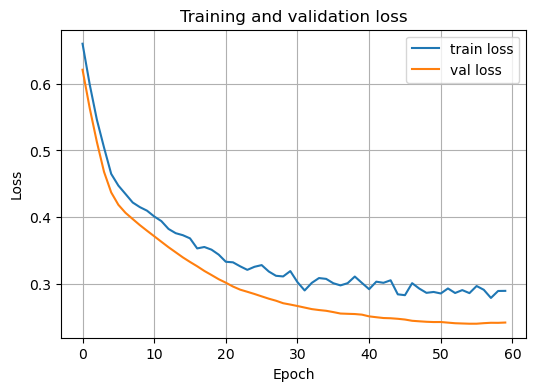

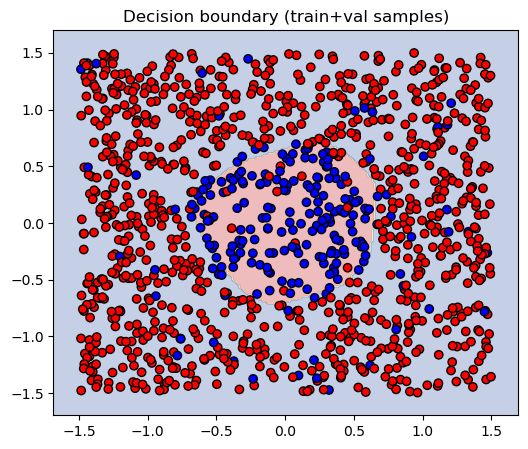

In [6]:
# Hyperparameters
TOTAL = 1200
BATCH = 64
EPOCHS = 60
LR = 1e-3
RADIUS = 0.7
NOISE = 0.05

train_loader, val_loader, test_loader, full_dataset = make_dataloaders(total_samples=TOTAL, train_frac=0.6, val_frac=0.2, batch_size=BATCH, radius=RADIUS, noise=NOISE)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device:', device)
model = FeedForwardNet(input_dim=2, hidden_sizes=[32,32], dropout=0.1)
history = train_model(model, train_loader, val_loader, epochs=EPOCHS, lr=LR, device=device)

plot_losses(history)
plot_decision_boundary(model, full_dataset, title='Decision boundary (train+val samples)')

# Task 3.2

In [7]:
import numpy as np
import pandas as pd

DEPTHS = [0, 1, 2, 3]       # number of hidden layers
WIDTHS = [1, 2, 3]          # units per hidden layer
REPEATS = 5                 # how many runs per (depth, width)

TOTAL_SAMPLES = 1200
BATCH_SIZE = 64
BASE_EPOCHS = 60
BASE_LR = 1e-3
RADIUS_OR_NOISE = 0.7
NOISE_LEVEL = 0.05

results = []

for depth in DEPTHS:
    for width in WIDTHS:
        run_losses = []
        print(f"\n=== Architecture: depth={depth}, width={width} ===")
        for run in range(REPEATS):
            # Fresh dataset each run
            train_loader, val_loader, test_loader, dataset = make_dataloaders(
                total_samples=TOTAL_SAMPLES,
                train_frac=0.6,
                val_frac=0.2,
                batch_size=BATCH_SIZE,
                radius=RADIUS_OR_NOISE,
                noise=NOISE_LEVEL,
            )

            hidden_sizes = [width] * depth  # depth=0 -> [] -> purely linear model
            model = FeedForwardNet(input_dim=2, hidden_sizes=hidden_sizes, dropout=0.0)

            # We can optionally use slightly fewer epochs for the sweep if BASE_EPOCHS is large
            sweep_epochs = min(BASE_EPOCHS, 60)
            _ = train_model(
                model,
                train_loader,
                val_loader,
                epochs=sweep_epochs,
                lr=BASE_LR,
                device=device,
            )

            test_loss, test_acc = evaluate(model, test_loader, device=device)
            run_losses.append(test_loss)
            print(f"  Run {run+1}/{REPEATS}: test_loss={test_loss:.4f}, test_acc={test_acc:.3f}")

        mean_loss = float(np.mean(run_losses))
        std_loss = float(np.std(run_losses, ddof=1)) if len(run_losses) > 1 else 0.0

        results.append({
            'depth': depth,
            'width': width,
            'mean_test_loss': mean_loss,
            'std_test_loss': std_loss,
        })
        print(f"--> depth={depth}, width={width}: mean_loss={mean_loss:.4f}, std_loss={std_loss:.4f}")

results_df = pd.DataFrame(results).sort_values(['depth', 'width']).reset_index(drop=True)
print("\nSummary over architectures (loss on new test sets):")
display(results_df)



=== Architecture: depth=0, width=1 ===
Epoch   1/60 | train_loss=0.6827 acc=0.549 | val_loss=0.6910 acc=0.537
Epoch   6/60 | train_loss=0.6591 acc=0.562 | val_loss=0.6696 acc=0.562
Epoch  12/60 | train_loss=0.6340 acc=0.575 | val_loss=0.6475 acc=0.583
Epoch  18/60 | train_loss=0.6119 acc=0.618 | val_loss=0.6279 acc=0.608
Epoch  24/60 | train_loss=0.5930 acc=0.661 | val_loss=0.6111 acc=0.650
Epoch  30/60 | train_loss=0.5767 acc=0.711 | val_loss=0.5969 acc=0.700
Epoch  36/60 | train_loss=0.5627 acc=0.758 | val_loss=0.5846 acc=0.754
Epoch  42/60 | train_loss=0.5513 acc=0.790 | val_loss=0.5746 acc=0.771
Epoch  48/60 | train_loss=0.5416 acc=0.810 | val_loss=0.5662 acc=0.783
Epoch  54/60 | train_loss=0.5332 acc=0.810 | val_loss=0.5589 acc=0.783
Epoch  60/60 | train_loss=0.5258 acc=0.810 | val_loss=0.5527 acc=0.783
  Run 1/5: test_loss=0.5259, test_acc=0.800
Epoch   1/60 | train_loss=0.6112 acc=0.751 | val_loss=0.6081 acc=0.775
Epoch   6/60 | train_loss=0.6002 acc=0.769 | val_loss=0.5965 acc

,depth,width,mean_test_loss,std_test_loss
0,0,1,0.513878,0.012849
1,0,2,0.556667,0.070429
2,0,3,0.633686,0.087541
3,1,1,0.549428,0.043993
4,1,2,0.535233,0.072600
5,1,3,0.464184,0.037947
6,2,1,0.543386,0.099542
7,2,2,0.547003,0.037441
8,2,3,0.501717,0.044947
9,3,1,0.582602,0.083052


# Task 3.4

In [8]:
import numpy as np
from torch.utils.data import Dataset, DataLoader, random_split

# Make sure SEED exists
try:
    SEED
except NameError:
    SEED = 42

class NoisyXORDataset(Dataset):
    """
    2D noisy XOR dataset.
    X ~ Uniform([-1, 1]^2)
    y = 1 if x1 and x2 have the same sign, else 0
    with optional label noise.
    """
    def __init__(self, n_samples=1200, noise=0.1):
        X = np.random.uniform(-1.0, 1.0, size=(n_samples, 2))
        # XOR: sign(x1)*sign(x2) > 0  -> same sign => class 1
        labels = ((X[:, 0] * X[:, 1]) > 0).astype(float)

        if noise > 0.0:
            flip_mask = np.random.rand(n_samples) < noise
            labels[flip_mask] = 1.0 - labels[flip_mask]

        self.X = X.astype(np.float32)
        self.y = labels.astype(np.float32).reshape(-1, 1)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


def make_xor_dataloaders(
    total_samples=1200,
    train_frac=0.6,
    val_frac=0.2,
    batch_size=64,
    noise=0.1,
):
    dataset = NoisyXORDataset(n_samples=total_samples, noise=noise)
    n_train = int(total_samples * train_frac)
    n_val = int(total_samples * val_frac)
    n_test = total_samples - n_train - n_val

    train_set, val_set, test_set = random_split(
        dataset,
        [n_train, n_val, n_test],
        generator=torch.Generator().manual_seed(SEED),
    )

    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_set, batch_size=batch_size, shuffle=False)
    test_loader  = DataLoader(test_set, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader, dataset


In [9]:
# Hyperparameters specific to XOR experiment
TOTAL_XOR = 1200
BATCH_XOR = 64
NOISE_XOR = 0.1

train_loader, val_loader, test_loader, full_dataset = make_xor_dataloaders(
    total_samples=TOTAL_XOR,
    train_frac=0.6,
    val_frac=0.2,
    batch_size=BATCH_XOR,
    noise=NOISE_XOR,
)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device:", device)
print("Train / val / test sizes:",
      len(train_loader.dataset), len(val_loader.dataset), len(test_loader.dataset))


Device: cpu
Train / val / test sizes: 720 240 240


In [10]:
import copy
import torch.nn as nn
import torch

class MinimalXORNet(nn.Module):
    """
    Minimal XOR network:
    - input: 2
    - hidden: 2 tanh units
    - output: 1 logit (for BCEWithLogitsLoss)
    """
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2, 2, bias=True)
        self.fc2 = nn.Linear(2, 1, bias=True)
        self.tanh = nn.Tanh()

    def forward(self, x):
        # x: (batch, 2)
        h = self.tanh(self.fc1(x))
        out = self.fc2(h).squeeze(-1)  # logits (batch,)
        return out


def train_minimal_xor(model, train_loader, val_loader, epochs=80, lr=1e-2, device='cpu'):
    """
    Train minimal XOR network and store weight snapshots after each epoch.
    Returns:
        history: dict with train/val losses
        snapshots: list of state_dicts (one per epoch)
    """
    model.to(device)
    loss_fn = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    history = {"train_loss": [], "val_loss": []}
    snapshots = []

    for ep in range(1, epochs + 1):
        model.train()
        running_loss = 0.0
        total = 0

        for xb, yb in train_loader:
            xb = xb.to(device).float()
            yb = yb.to(device).float().squeeze(-1)

            optimizer.zero_grad()
            logits = model(xb)
            loss = loss_fn(logits, yb)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * xb.size(0)
            total += xb.size(0)

        train_loss = running_loss / total
        val_loss, _ = evaluate(model, val_loader, device=device)

        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)

        snapshots.append(copy.deepcopy(model.state_dict()))

        if ep % max(1, epochs // 10) == 0 or ep == 1:
            print(f"Epoch {ep:3d}/{epochs} | train_loss={train_loss:.4f} | val_loss={val_loss:.4f}")

    return history, snapshots


In [11]:
EPOCHS_XOR = 80
LR_XOR     = 1e-2

xor_model = MinimalXORNet()
print("Training minimal XOR network on noisy XOR data...")
xor_history, xor_snapshots = train_minimal_xor(
    xor_model,
    train_loader,
    val_loader,
    epochs=EPOCHS_XOR,
    lr=LR_XOR,
    device=device,
)

test_loss, test_acc = evaluate(xor_model, test_loader, device=device)
print(f"Final test loss: {test_loss:.4f}, test accuracy: {test_acc:.3f}")


Training minimal XOR network on noisy XOR data...
Epoch   1/80 | train_loss=0.7057 | val_loss=0.7014
Epoch   8/80 | train_loss=0.6897 | val_loss=0.6921
Epoch  16/80 | train_loss=0.6551 | val_loss=0.6692
Epoch  24/80 | train_loss=0.6050 | val_loss=0.6394
Epoch  32/80 | train_loss=0.5876 | val_loss=0.6331
Epoch  40/80 | train_loss=0.5814 | val_loss=0.6305
Epoch  48/80 | train_loss=0.5787 | val_loss=0.6301
Epoch  56/80 | train_loss=0.5769 | val_loss=0.6299
Epoch  64/80 | train_loss=0.5759 | val_loss=0.6308
Epoch  72/80 | train_loss=0.5749 | val_loss=0.6301
Epoch  80/80 | train_loss=0.5745 | val_loss=0.6315
Final test loss: 0.5911, test accuracy: 0.592


In [12]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

def plot_xor_decision_boundaries(model, dataset, device='cpu', epoch_idx=None):
    """
    Plot:
      - training data points
      - two hidden unit decision boundaries (pre-activation = 0)
      - output decision boundary (logit = 0 => p=0.5)
    """
    model.to(device).eval()

    X = dataset.X
    y = dataset.y.squeeze(-1)
    X = np.asarray(X)
    y = np.asarray(y)

    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1

    fig, ax = plt.subplots(figsize=(5, 5))

    # data (kept out of legend)
    ax.scatter(
        X[:, 0],
        X[:, 1],
        c=y,
        cmap="bwr",
        edgecolor="k",
        alpha=0.6,
    )

    with torch.no_grad():
        # hidden boundaries: w1*x1 + w2*x2 + b = 0 for each hidden unit
        W1 = model.fc1.weight.detach().cpu().numpy()  # (2,2)
        b1 = model.fc1.bias.detach().cpu().numpy()    # (2,)

        xx = np.linspace(x_min, x_max, 400)
        styles = ["--", "-."]

        for j, style in enumerate(styles):
            w = W1[j]
            b = b1[j]

            if abs(w[1]) < 1e-6:
                x_line = -b / w[0]
                ax.axvline(x_line, linestyle=style, color=f"C{j}")
            else:
                yy_line = -(w[0] * xx + b) / w[1]
                ax.plot(xx, yy_line, linestyle=style, color=f"C{j}")

        # output boundary: logit = 0
        gx, gy = np.meshgrid(
            np.linspace(x_min, x_max, 300),
            np.linspace(y_min, y_max, 300),
        )
        grid = np.c_[gx.ravel(), gy.ravel()]
        grid_t = torch.from_numpy(grid).float().to(device)
        logits = model(grid_t).detach().cpu().numpy().reshape(gx.shape)

        ax.contour(
            gx,
            gy,
            logits,
            levels=[0.0],
            colors="black",
            linewidths=2,
        )

    title = "Decision boundaries"
    if epoch_idx is not None:
        title += f" (epoch {epoch_idx+1})"
    ax.set_title(title)
    ax.set_xlabel("$x_1$")
    ax.set_ylabel("$x_2$")

    # explicit legend
    custom_lines = [
        Line2D([0], [0], color="C0", linestyle="--", label="hidden 1 boundary"),
        Line2D([0], [0], color="C1", linestyle="-.", label="hidden 2 boundary"),
        Line2D([0], [0], color="black", linestyle="-", label="output boundary (p=0.5)"),
    ]
    ax.legend(handles=custom_lines, loc="best")

    return fig, ax


In [13]:
import os
import numpy as np
import imageio.v2 as imageio
from PIL import Image

frame_dir = "xor_frames"
os.makedirs(frame_dir, exist_ok=True)

print("Generating frames for decision boundary movie...")
for ep in range(len(xor_snapshots)):
    snapshot_model = MinimalXORNet()
    snapshot_model.load_state_dict(xor_snapshots[ep])

    fig, ax = plot_xor_decision_boundaries(
        snapshot_model,
        full_dataset,
        device=device,
        epoch_idx=ep,
    )
    frame_path = os.path.join(frame_dir, f"xor_epoch_{ep+1:03d}.png")
    fig.savefig(frame_path, dpi=120)   # no bbox_inches="tight"
    plt.close(fig)

print(f"Saved {len(xor_snapshots)} frames in '{frame_dir}/'.")

# Build GIF
frame_files = sorted(f for f in os.listdir(frame_dir) if f.endswith(".png"))

frames = []
ref_size = None

for fname in frame_files:
    path = os.path.join(frame_dir, fname)
    im = Image.open(path).convert("RGB")

    if ref_size is None:
        ref_size = im.size
    elif im.size != ref_size:
        im = im.resize(ref_size, Image.BILINEAR)

    frames.append(np.array(im))

gif_path = "xor_decision_boundaries.gif"
imageio.mimsave(gif_path, frames, duration=0.2)
print(f"Saved movie to '{gif_path}'.")


Generating frames for decision boundary movie...
Saved 80 frames in 'xor_frames/'.
Saved movie to 'xor_decision_boundaries.gif'.


In [14]:
# Choose a few interesting epochs: 1, 10, 40, final
important_epochs = [0, 9, 39, len(xor_snapshots) - 1]  # 0-based indices

snap_dir = "xor_snapshots_report"
os.makedirs(snap_dir, exist_ok=True)

for ep in important_epochs:
    snapshot_model = MinimalXORNet()
    snapshot_model.load_state_dict(xor_snapshots[ep])

    fig, ax = plot_xor_decision_boundaries(
        snapshot_model,
        full_dataset,
        device=device,
        epoch_idx=ep,
    )
    snap_path = os.path.join(snap_dir, f"xor_snapshot_epoch_{ep+1:03d}.png")
    fig.savefig(snap_path, dpi=150)
    plt.close(fig)

print("Saved report snapshots in:", snap_dir)


Saved report snapshots in: xor_snapshots_report
